In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [18]:
#Load Data Set
df= pd.read_csv('air_pollution_data.csv')

In [19]:
df.head(3)

,city,date,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,Ahmedabad,30-11-2020,5,520.71,2.38,16.28,130.18,47.68,65.96,72.13,8.36
1,Ahmedabad,01-12-2020,5,1682.28,7.71,54.84,0.73,21.70,120.95,154.53,27.36
2,Ahmedabad,02-12-2020,5,1815.80,16.54,49.35,0.17,23.84,133.47,172.63,28.12


In [20]:
df.info

<bound method DataFrame.info of                 city        date  aqi       co     no    no2      o3    so2  \
0          Ahmedabad  30-11-2020    5   520.71   2.38  16.28  130.18  47.68   
1          Ahmedabad  01-12-2020    5  1682.28   7.71  54.84    0.73  21.70   
2          Ahmedabad  02-12-2020    5  1815.80  16.54  49.35    0.17  23.84   
3          Ahmedabad  03-12-2020    5  2296.45  41.57  40.10    0.00  35.76   
4          Ahmedabad  04-12-2020    5  2189.64  23.92  58.95    0.02  28.13   
...              ...         ...  ...      ...    ...    ...     ...    ...   
23499  Visakhapatnam  21-05-2023    3   353.81   0.00   2.08  100.14   4.11   
23500  Visakhapatnam  22-05-2023    3   380.52   0.00   3.77   82.97   5.07   
23501  Visakhapatnam  23-05-2023    3   390.53   0.00   4.28   80.11   5.19   
23502  Visakhapatnam  24-05-2023    3   300.41   0.00   1.36   95.84   2.21   
23503  Visakhapatnam  25-05-2023    4   427.25   0.00   6.00   88.69  10.73   

        pm2_5    pm

### Clean Column Names

In [21]:
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace('.', '_')
    .str.replace('-', '_')
)

print("Cleaned columns:")
print(df.columns)


Cleaned columns:
Index(['city', 'date', 'aqi', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10',
       'nh3'],
      dtype='object')


In [22]:
import warnings
warnings.filterwarnings('ignore')

### Convert Date Column to Datetime

In [23]:
df['date'] = pd.to_datetime(df['date'])

df = df.sort_values('date')
df.set_index('date', inplace=True)

### Handle Missing Values

In [24]:
print("Missing values before cleaning:")
print(df.isnull().sum())

df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

Missing values before cleaning:
city     0
aqi      0
co       0
no       0
no2      0
o3       0
so2      0
pm2_5    0
pm10     0
nh3      0
dtype: int64


### Automatically Select Target Column

In [25]:
if 'aqi' in df.columns:
    target_col = 'aqi'
elif 'pm2_5' in df.columns:
    target_col = 'pm2_5'
elif 'pm10' in df.columns:
    target_col = 'pm10'
else:
    raise ValueError("No AQI / PM2.5 / PM10 column found")

print("Target column selected:", target_col)

Target column selected: aqi


### Create Time-Based Features

In [26]:
df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df['weekday'] = df.index.weekday

### Create Lag Features

In [27]:
for lag in [1, 2, 3]:
    df[f'{target_col}_lag{lag}'] = df[target_col].shift(lag)

df.dropna(inplace=True)

print("Lag features created successfully")

Lag features created successfully


In [28]:
X = df.drop(columns=[target_col])
y = df[target_col]

### Train–Test Split (Time-Series Safe)

In [31]:
split_index = int(len(df) * 0.8)

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]

In [33]:
# Keep only numeric features
X = X.select_dtypes(include=[np.number])

print("Remaining feature columns:")
print(X.columns)

# Re-split after fixing X
split_index = int(len(X) * 0.8)

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]


Remaining feature columns:
Index(['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3', 'hour', 'day',
       'month', 'weekday', 'aqi_lag1', 'aqi_lag2', 'aqi_lag3'],
      dtype='object')


### Feature Scaling

In [34]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Train the Machine Learning Model

In [35]:
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    random_state=42
)

model.fit(X_train_scaled, y_train)

,n_estimators,200
,criterion,'squared_error'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [36]:
#make predic
y_pred = model.predict(X_test_scaled)

### Evaluate the Model

In [37]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE :", mae)
print("RMSE:", rmse)
print("R2  :", r2)

MAE : 0.36944373537545205
RMSE: 0.6073404724525069
R2  : 0.7024833453420123


### Plot Actual vs Predicted Values

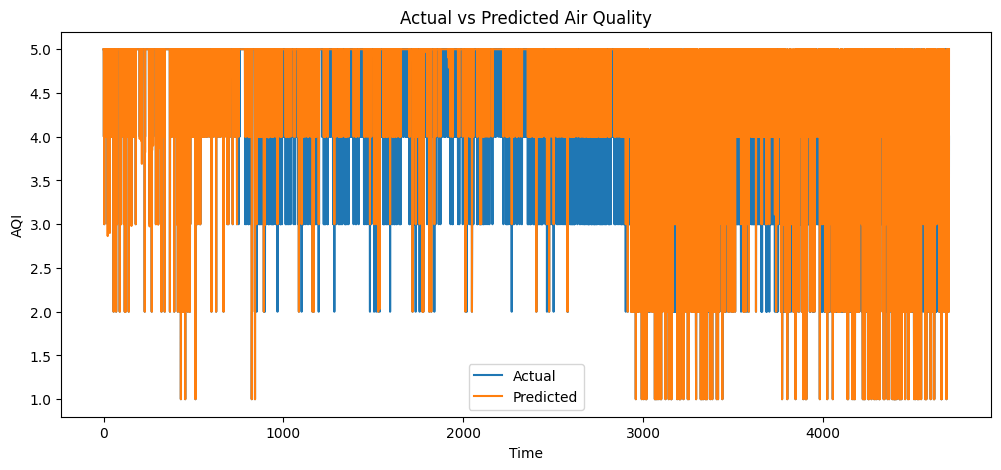

In [38]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Air Quality')
plt.xlabel('Time')
plt.ylabel(target_col.upper())
plt.legend()
plt.show()